In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
from keras import backend as K

from imageio import mimsave
from IPython.display import display as display_fn
from IPython.display import Image, clear_output


In [2]:
def tensor_to_image(tensor):
  '''converts a tensor to an image'''
  tensor_shape = tf.shape(tensor)
  number_elem_shape = tf.shape(tensor_shape)
  if number_elem_shape > 3:
    assert tensor_shape[0] == 1
    tensor = tensor[0]
  return tf.keras.preprocessing.image.array_to_img(tensor) 


def load_img(path_to_img):
  '''loads an image as a tensor and scales it to 512 pixels'''
  max_dim = 512
  image = tf.io.read_file(path_to_img)
  image = tf.image.decode_jpeg(image)
  image = tf.image.convert_image_dtype(image, tf.float32)

  shape = tf.shape(image)[:-1]
  shape = tf.cast(tf.shape(image)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  image = tf.image.resize(image, new_shape)
  image = image[tf.newaxis, :]
  image = tf.image.convert_image_dtype(image, tf.uint8)

  return image


def load_images(content_path, style_path):
  '''loads the content and path images as tensors'''
  content_image = load_img("{}".format(content_path))
  style_image = load_img("{}".format(style_path))

  return content_image, style_image


def imshow(image, title=None):
  '''displays an image with a corresponding title'''
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)
    
    
def show_images_with_objects(images, titles=[]):
  '''displays a row of images with corresponding titles'''
  if len(images) != len(titles):
    return

  plt.figure(figsize=(20, 12))
  for idx, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(1, len(images), idx + 1)
    plt.xticks([])
    plt.yticks([])
    imshow(image, title)


def display_gif(gif_path):
  '''displays the generated images as an animated gif'''
  with open(gif_path,'rb') as f:
    display_fn(Image(data=f.read(), format='png'))


def create_gif(gif_path, images):
  '''creates animation of generated images'''
  mimsave(gif_path, images, fps=1)
  
  return gif_path


def clip_image_values(image, min_value=0.0, max_value=255.0):
  '''clips the image pixel values by the given min and max'''
  return tf.clip_by_value(image, clip_value_min=min_value, clip_value_max=max_value)


def preprocess_image(image):
  '''centers the pixel values of a given image to use with VGG-19'''
  image = tf.cast(image, dtype=tf.float32)
  image = tf.keras.applications.vgg19.preprocess_input(image)

  return image


In [3]:
# set default images
content_path = f'swan.jpg'
style_path = f'style.jpg'

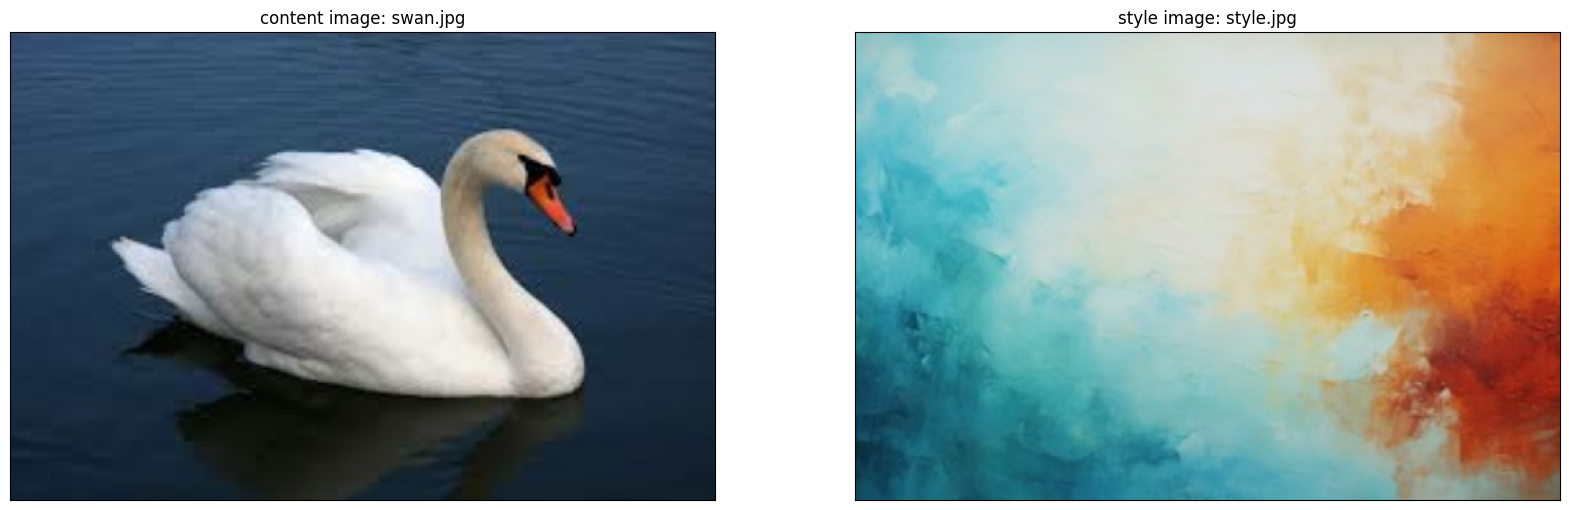

In [4]:
# display the content and style image
content_image, style_image = load_images(content_path, style_path)
show_images_with_objects([content_image, style_image], 
                         titles=[f'content image: {content_path}',
                                 f'style image: {style_path}'])

In [5]:
# clear session to make layer naming consistent when re-running this cell
K.clear_session()

# download the vgg19 model and inspect the layers
tmp_vgg = tf.keras.applications.vgg19.VGG19()
tmp_vgg.summary()

# delete temporary variable
del tmp_vgg

Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,31

 Total params: 143,667,240 (548.05 MB)

 Trainable params: 143,667,240 (548.05 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# style layers of interest
style_layers = ['block1_conv1', 
                'block2_conv1', 
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1'] 

# choose the content layer and put in a list
content_layers = ['block5_conv2'] 

# combine the two lists (put the style layers before the content layers)
output_layers = style_layers + content_layers 

# declare auxiliary variables holding the number of style and content layers
NUM_CONTENT_LAYERS = len(content_layers)
NUM_STYLE_LAYERS = len(style_layers)

In [7]:
def vgg_model(layer_names):
  

  # load the the pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')

  # freeze the weights of the model's layers (make them not trainable)
  vgg.trainable = False
  
  # create a list of layer objects that are specified by layer_names
  outputs = [vgg.get_layer(name).output for name in layer_names]

  # create the model that outputs content and style layers only
  model = tf.keras.Model(inputs=vgg.input, outputs=outputs)

  return model

In [8]:
# clear session to make layer naming consistent if re-running the cell
K.clear_session()

# create a vgg-19 model
vgg = vgg_model(output_layers)
vgg.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 15,304,768 (58.38 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 15,304,768 (58.38 MB)

In [9]:
def get_style_loss(features, targets):
 
  # get the average of the squared errors
  style_loss = tf.reduce_mean(tf.square(features - targets))
    
  return style_loss

In [10]:
def get_content_loss(features, targets):
 
  # get the sum of the squared error multiplied by a scaling factor
  content_loss = 0.5 * tf.reduce_sum(tf.square(features - targets))
    
  return content_loss

In [11]:
def gram_matrix(input_tensor):

  # calculate the gram matrix of the input tensor
  gram = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor) 

  # get the height and width of the input tensor
  input_shape = tf.shape(input_tensor) 
  height = input_shape[1] 
  width = input_shape[2] 

  # get the number of locations (height times width), and cast it as a tf.float32
  num_locations = tf.cast(height * width, tf.float32)

  # scale the gram matrix by dividing by the number of locations
  scaled_gram = gram / num_locations
    
  return scaled_gram

In [12]:
tmp_layer_list = [layer.output for layer in vgg.layers]
tmp_layer_list

[<KerasTensor shape=(None, None, None, 3), dtype=float32, sparse=False, name=keras_tensor>,
 <KerasTensor shape=(None, None, None, 64), dtype=float32, sparse=False, name=keras_tensor_1>,
 <KerasTensor shape=(None, None, None, 64), dtype=float32, sparse=False, name=keras_tensor_2>,
 <KerasTensor shape=(None, None, None, 64), dtype=float32, sparse=False, name=keras_tensor_3>,
 <KerasTensor shape=(None, None, None, 128), dtype=float32, sparse=False, name=keras_tensor_4>,
 <KerasTensor shape=(None, None, None, 128), dtype=float32, sparse=False, name=keras_tensor_5>,
 <KerasTensor shape=(None, None, None, 128), dtype=float32, sparse=False, name=keras_tensor_6>,
 <KerasTensor shape=(None, None, None, 256), dtype=float32, sparse=False, name=keras_tensor_7>,
 <KerasTensor shape=(None, None, None, 256), dtype=float32, sparse=False, name=keras_tensor_8>,
 <KerasTensor shape=(None, None, None, 256), dtype=float32, sparse=False, name=keras_tensor_9>,
 <KerasTensor shape=(None, None, None, 256), dt

In [13]:
def get_style_image_features(image):  
 
  # preprocess the image using the given preprocessing function
  preprocessed_style_image = preprocess_image(image) 

  # get the outputs from the custom vgg model that you created using vgg_model()
  outputs = vgg(preprocessed_style_image) 

  # Get just the style feature layers (exclude the content layer)
  style_outputs = outputs[:NUM_STYLE_LAYERS] 

  # for each style layer, calculate the gram matrix for that layer and store these results in a list
  gram_style_features = [gram_matrix(style_layer) for style_layer in style_outputs] 

  return gram_style_features

In [14]:
def get_content_image_features(image):

  # preprocess the image = preprocess_image(image)
    
  # get the outputs from the vgg model
  outputs = vgg(preprocessed_content_image) 

  # get the content layers of the outputs
  content_outputs = outputs[NUM_STYLE_LAYERS:]

  # return the content layer outputs of the content image
  return content_outputs

In [15]:
def get_style_content_loss(style_targets, style_outputs, content_targets, 
                           content_outputs, style_weight, content_weight):
 
    
  # sum of the style losses
  style_loss = tf.add_n([ get_style_loss(style_output, style_target)
                           for style_output, style_target in zip(style_outputs, style_targets)])
  
  # Sum up the content losses
  content_loss = tf.add_n([get_content_loss(content_output, content_target)
                           for content_output, content_target in zip(content_outputs, content_targets)])

  # scale the style loss by multiplying by the style weight and dividing by the number of style layers
  style_loss = style_loss * style_weight / NUM_STYLE_LAYERS 

  # scale the content loss by multiplying by the content weight and dividing by the number of content layers
  content_loss = content_loss * content_weight / NUM_CONTENT_LAYERS 
    
  # sum up the style and content losses
  total_loss = style_loss + content_loss 

  return total_loss

In [16]:
def calculate_gradients(image, style_targets, content_targets, 
                        style_weight, content_weight, var_weight):

  with tf.GradientTape() as tape:
      
    # get the style image features
    style_features = get_style_image_features(image) 
      
    # get the content image features
    content_features = get_content_image_features(image) 
      
    # get the style and content loss
    loss = get_style_content_loss(style_targets, style_features, content_targets, 
                                  content_features, style_weight, content_weight) 

  # calculate gradients of loss with respect to the image
  gradients = tape.gradient(loss, image) 

  return gradients

In [17]:
def update_image_with_style(image, style_targets, content_targets, style_weight, 
                            var_weight, content_weight, optimizer):


  # calculate gradients using the function that you just defined.
  gradients = calculate_gradients(image, style_targets, content_targets, 
                                  style_weight, content_weight, var_weight) 

  # apply the gradients to the given image
  optimizer.apply_gradients([(gradients, image)]) 

  # clip the image using the utility clip_image_values() function
  image.assign(clip_image_values(image, min_value=0.0, max_value=255.0))

In [18]:
def fit_style_transfer(style_image, content_image, style_weight=1e-2, content_weight=1e-4, 
                       var_weight=0, optimizer='adam', epochs=1, steps_per_epoch=1):

  images = []
  step = 0

  # get the style image features 
  style_targets = get_style_image_features(style_image)
    
  # get the content image features
  content_targets = get_content_image_features(content_image)

  # initialize the generated image for updates
  generated_image = tf.cast(content_image, dtype=tf.float32)
  generated_image = tf.Variable(generated_image) 
  
  # collect the image updates starting from the content image
  images.append(content_image)
  
  # incrementally update the content image with the style features
  for n in range(epochs):
    for m in range(steps_per_epoch):
      step += 1
    
      # Update the image with the style using the function that you defined
      update_image_with_style(generated_image, style_targets, content_targets, 
                              style_weight, var_weight, content_weight, optimizer) 
    
      print(".", end='')

      if (m + 1) % 10 == 0:
        images.append(generated_image)
    
    # display the current stylized image
    clear_output(wait=True)
    display_image = tensor_to_image(generated_image)
    display_fn(display_image)

    # append to the image collection for visualization later
    images.append(generated_image)
    print("Train step: {}".format(step))
  
  # convert to uint8 (expected dtype for images with pixels in the range [0,255])
  generated_image = tf.cast(generated_image, dtype=tf.uint8)

  return generated_image, images

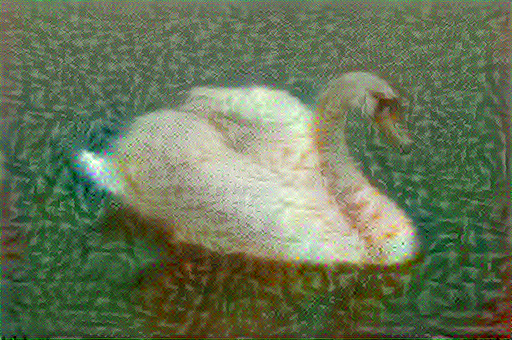

Train step: 100


In [19]:
# define style and content weight
style_weight =  2e-2
content_weight = 1e-2 

# define optimizer. learning rate decreases per epoch.
adam = tf.optimizers.Adam(
    tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=20.0, decay_steps=100, decay_rate=0.50
    )
)

# start the neural style transfer
stylized_image, display_images = fit_style_transfer(style_image=style_image, content_image=content_image, 
                                                    style_weight=style_weight, content_weight=content_weight,
                                                    var_weight=0, optimizer=adam, epochs=10, steps_per_epoch=10)

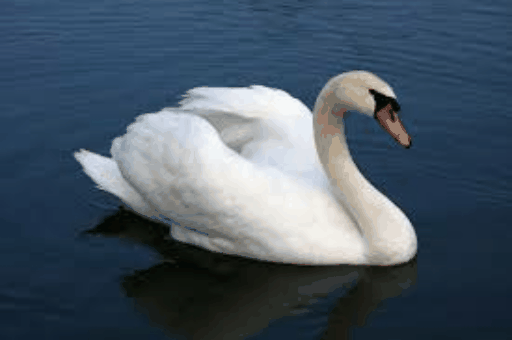

In [20]:
# display GIF of Intermedite Outputs
GIF_PATH = 'style_transfer.gif'
gif_images = [np.squeeze(image.numpy().astype(np.uint8), axis=0) for image in display_images]
gif_path = create_gif(GIF_PATH, gif_images)
display_gif(gif_path)